<a href="https://colab.research.google.com/github/bhargav23/NLP-Projects/blob/main/Upgraded_Sentiment_Analysis_16-01-2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bhargav23","key":"2af4a1f81e53cbe18d6150037d44abcb"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

 96% 233M/242M [00:02<00:00, 87.2MB/s]
100% 242M/242M [00:02<00:00, 90.0MB/s]


In [5]:
!unzip amazon-fine-food-reviews.zip -d data

Archive:  amazon-fine-food-reviews.zip
  inflating: data/Reviews.csv        
  inflating: data/database.sqlite    
  inflating: data/hashes.txt         


In [6]:
DATA_PATH = 'data/Reviews.csv'

In [7]:
import pandas as pd
import numpy as np

In [8]:
odf = pd.read_csv('data/Reviews.csv')
#odf['Helpful %'] = np.where(odf['HelpfulnessDenominator'] > 0, odf['HelpfulnessNumerator'] / odf['HelpfulnessDenominator'], -1)
#odf['% Upvote'] = pd.cut(odf['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)

In [9]:
df = odf[odf['Score'] != 3]
X = df['Text']
y_dict = {1:'neg', 2:'neg', 4:'pos', 5:'pos'}
y = df['Score'].map(y_dict)

In [10]:
import torch

In [11]:
TEXT = pd.Series(X,name="Text")
train_df = pd.concat([TEXT, y], axis=1)

In [12]:
train_df.head()

,Text,Score
0,I have bought several of the Vitality canned d...,pos
1,Product arrived labeled as Jumbo Salted Peanut...,neg
2,This is a confection that has been around a fe...,pos
3,If you are looking for the secret ingredient i...,neg
4,Great taffy at a great price. There was a wid...,pos


In [13]:
train_df.dtypes

Text     object
Score    object
dtype: object

In [14]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)

In [15]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 420651
Number of testing examples: 105163


Then create the validation set from our training set.

In [16]:
import random
SEED = 1234
train_data, valid_data = train_test_split(train_data,random_state = random.seed(SEED))

In [17]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 315488
Number of validation examples: 105163
Number of testing examples: 105163


Next is the use of pre-trained word embeddings. Now, instead of having our word embeddings initialized randomly, they are initialized with these pre-trained vectors.
We get these vectors simply by specifying which vectors we want and passing it as an argument to `build_vocab`. `TorchText` handles downloading the vectors and associating them with the correct words in our vocabulary.

Here, we'll be using the `"glove.6B.100d" vectors"`. `glove` is the algorithm used to calculate the vectors, go [here](https://nlp.stanford.edu/projects/glove/) for more. `6B` indicates these vectors were trained on 6 billion tokens and `100d` indicates these vectors are 100-dimensional.

You can see the other available vectors [here](https://github.com/pytorch/text/blob/master/torchtext/vocab.py#L113).

The theory is that these pre-trained vectors already have words with similar semantic meaning close together in vector space, e.g. "terrible", "awful", "dreadful" are nearby. This gives our embedding layer a good initialization as it does not have to learn these relations from scratch.

**Note**: these vectors are about 862MB, so watch out if you have a limited internet connection.

By default, TorchText will initialize words in your vocabulary but not in your pre-trained embeddings to zero. We don't want this, and instead initialize them randomly by setting `unk_init` to `torch.Tensor.normal_`. This will now initialize those words via a Gaussian distribution.

In [18]:
from torchtext import data
from torchtext import datasets
 
SEED = 1234
 
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
 
TEXT = data.Field(tokenize = 'spacy',include_lengths = True)
SCORE = data.LabelField(dtype = torch.float)

In [19]:
fields = {'Text': ('t', TEXT), 'Score': ('s', SCORE)}

In [20]:
train_data.to_csv('train.csv')
valid_data.to_csv('valid.csv')
test_data.to_csv('test.csv')

In [21]:
train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = '',
                                        train = 'train.csv',
                                        validation = 'valid.csv',
                                        test = 'test.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = False
)

In [22]:
print(vars(train_data[0]))

{'t': ['I', 'subscribe', 'and', 'save', ',', 'which', 'gives', 'me', 'a', 'great', 'value', 'on', 'these', 'KIND', 'bars', ',', 'which', 'I', 'would', 'normally', 'see', 'as', 'too', 'expensive', '.', 'This', 'flavor', 'is', 'the', 'best', 'snack', 'or', 'quick', 'breakfast', '.', 'I', 'keep', 'them', 'in', 'my', 'office', 'cubicle', 'in', 'case', 'I', 'need', 'a', 'healthy', 'snack', '.', 'They', "'re", 'incredibly', 'sweet', ',', 'great', 'for', 'when', 'I', 'have', 'cravings', 'for', 'cola', '.'], 's': 'pos'}


In [23]:
MAX_VOCAB_SIZE = 25000
TEXT.build_vocab(train_data,max_size=MAX_VOCAB_SIZE,vectors = "glove.6B.100d",unk_init = torch.Tensor.normal_)
SCORE.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:27, 2.22MB/s]                           
 99%|█████████▉| 397748/400000 [00:15<00:00, 26294.97it/s]

As before, we create the iterators, placing the tensors on the GPU if one is available.

Another thing for packed padded sequences all of the tensors within a batch need to be sorted by their lengths. This is handled in the iterator by setting `sort_within_batch = True`.

In [24]:
print(SCORE.vocab.itos)

['pos', 'neg']


In [25]:


BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort_key = lambda x: len(x.t), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

"""
BATCH_SIZE = 64
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort_key = lambda x: len(x.t), #sort by s attribute (quote)
    batch_size=BATCH_SIZE,
    device=device)
"""

"\nBATCH_SIZE = 64\n \ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\n\ntrain_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(\n    (train_data, valid_data, test_data),\n    sort_key = lambda x: len(x.t), #sort by s attribute (quote)\n    batch_size=BATCH_SIZE,\n    device=device)\n"

In [26]:
device

device(type='cuda')

In [27]:
SCORE.vocab.itos

['pos', 'neg']

## Build the Model

The model features the most drastic changes.

### Different RNN Architecture

We'll be using a different RNN architecture called a Long Short-Term Memory (LSTM). Why is an LSTM better than a standard RNN? Standard RNNs suffer from the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). LSTMs overcome this by having an extra recurrent state called a _cell_, $c$ - which can be thought of as the "memory" of the LSTM - and the use use multiple _gates_ which control the flow of information into and out of the memory. For more information, go [here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/). We can simply think of the LSTM as a function of $x_t$, $h_t$ and $c_t$, instead of just $x_t$ and $h_t$.

$$(h_t, c_t) = \text{LSTM}(x_t, h_t, c_t)$$

Thus, the model using an LSTM looks something like (with the embedding layers omitted):

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment2.png?raw=1)

The initial cell state, $c_0$, like the initial hidden state is initialized to a tensor of all zeros. The sentiment prediction is still, however, only made using the final hidden state, not the final cell state, i.e. $\hat{y}=f(h_T)$.

### Bidirectional RNN

The concept behind a bidirectional RNN is simple. As well as having an RNN processing the words in the sentence from the first to the last (a forward RNN), we have a second RNN processing the words in the sentence from the **last to the first** (a backward RNN). At time step $t$, the forward RNN is processing word $x_t$, and the backward RNN is processing word $x_{T-t+1}$. 

In PyTorch, the hidden state (and cell state) tensors returned by the forward and backward RNNs are stacked on top of each other in a single tensor. 

We make our sentiment prediction using a concatenation of the last hidden state from the forward RNN (obtained from final word of the sentence), $h_T^\rightarrow$, and the last hidden state from the backward RNN (obtained from the first word of the sentence), $h_T^\leftarrow$, i.e. $\hat{y}=f(h_T^\rightarrow, h_T^\leftarrow)$   

The image below shows a bi-directional RNN, with the forward RNN in orange, the backward RNN in green and the linear layer in silver.  

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment3.png?raw=1)

### Multi-layer RNN

Multi-layer RNNs (also called *deep RNNs*) are another simple concept. The idea is that we add additional RNNs on top of the initial standard RNN, where each RNN added is another *layer*. The hidden state output by the first (bottom) RNN at time-step $t$ will be the input to the RNN above it at time step $t$. The prediction is then made from the final hidden state of the final (highest) layer.

The image below shows a multi-layer unidirectional RNN, where the layer number is given as a superscript. Also note that each layer needs their own initial hidden state, $h_0^L$.

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment4.png?raw=1)

### Regularization

Although we've added improvements to our model, each one adds additional parameters. Without going into overfitting into too much detail, the more parameters you have in in your model, the higher the probability that your model will overfit (memorize the training data, causing  a low training error but high validation/testing error, i.e. poor generalization to new, unseen examples). To combat this, we use regularization. More specifically, we use a method of regularization called *dropout*. Dropout works by randomly *dropping out* (setting to 0) neurons in a layer during a forward pass. The probability that each neuron is dropped out is set by a hyperparameter and each neuron with dropout applied is considered indepenently. One theory about why dropout works is that a model with parameters dropped out can be seen as a "weaker" (less parameters) model. The predictions from all these "weaker" models (one for each forward pass) get averaged together withinin the parameters of the model. Thus, your one model can be thought of as an ensemble of weaker models, none of which are over-parameterized and thus should not overfit.

### Implementation Details

Another addition to this model is that we are not going to learn the embedding for the `<pad>` token. This is because we want to explitictly tell our model that padding tokens are irrelevant to determining the sentiment of a sentence. This means the embedding for the pad token will remain at what it is initialized to (we initialize it to all zeros later). We do this by passing the index of our pad token as the `padding_idx` argument to the `nn.Embedding` layer.

To use an LSTM instead of the standard RNN, we use `nn.LSTM` instead of `nn.RNN`. Also, note that the LSTM returns the `output` and a tuple of the final `hidden` state and the final `cell` state, whereas the standard RNN only returned the `output` and final `hidden` state. 

As the final hidden state of our LSTM has both a forward and a backward component, which will be concatenated together, the size of the input to the `nn.Linear` layer is twice that of the hidden dimension size.

Implementing bidirectionality and adding additional layers are done by passing values for the `num_layers` and `bidirectional` arguments for the RNN/LSTM. 

Dropout is implemented by initializing an `nn.Dropout` layer (the argument is the probability of dropping out each neuron) and using it within the `forward` method after each layer we want to apply dropout to. **Note**: never use dropout on the input or output layers (`text` or `fc` in this case), you only ever want to use dropout on intermediate layers. The LSTM has a `dropout` argument which adds dropout on the connections between hidden states in one layer to hidden states in the next layer. 

As we are passing the lengths of our sentences to be able to use packed padded sequences, we have to add a second argument, `text_lengths`, to `forward`. 

Before we pass our embeddings to the RNN, we need to pack them, which we do with `nn.utils.rnn.packed_padded_sequence`. This will cause our RNN to only process the non-padded elements of our sequence. The RNN will then return `packed_output` (a packed sequence) as well as the `hidden` and `cell` states (both of which are tensors). Without packed padded sequences, `hidden` and `cell` are tensors from the last element in the sequence, which will most probably be a pad token, however when using packed padded sequences they are both from the last non-padded element in the sequence. 

We then unpack the output sequence, with `nn.utils.rnn.pad_packed_sequence`, to transform it from a packed sequence to a tensor. The elements of `output` from padding tokens will be zero tensors (tensors where every element is zero). Usually, we only have to unpack output if we are going to use it later on in the model. Although we aren't in this case, we still unpack the sequence just to show how it is done.

The final hidden state, `hidden`, has a shape of _**[num layers * num directions, batch size, hid dim]**_. These are ordered: **[forward_layer_0, backward_layer_0, forward_layer_1, backward_layer 1, ..., forward_layer_n, backward_layer n]**. As we want the final (top) layer forward and backward hidden states, we get the top two hidden layers from the first dimension, `hidden[-2,:,:]` and `hidden[-1,:,:]`, and concatenate them together before passing them to the linear layer (after applying dropout). 

In [28]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

Like before, we'll create an instance of our RNN class, with the new parameters and arguments for the number of layers, bidirectionality and dropout probability.

To ensure the pre-trained vectors can be loaded into the model, the `EMBEDDING_DIM` must be equal to that of the pre-trained GloVe vectors loaded earlier.

We get our pad token index from the vocabulary, getting the actual string representing the pad token from the field's `pad_token` attribute, which is `<pad>` by default.

In [29]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

We'll print out the number of parameters in our model. 

Notice how we have almost twice as many parameters as before!

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,810,857 trainable parameters


The final addition is copying the pre-trained word embeddings we loaded earlier into the `embedding` layer of our model.

We retrieve the embeddings from the field's vocab, and check they're the correct size, _**[vocab size, embedding dim]**_ 

In [31]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([25002, 100])


We then replace the initial weights of the `embedding` layer with the pre-trained embeddings.

**Note**: this should always be done on the `weight.data` and not the `weight`!

In [32]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [-0.1137,  0.0449, -0.0762,  ..., -0.0996,  0.0363, -0.2004],
        [ 0.2973, -1.0585,  0.3059,  ...,  0.0859, -0.3821, -0.3014],
        [ 0.6246,  1.0080,  1.8836,  ..., -0.0828, -0.0667, -1.1450]])

As our `<unk>` and `<pad>` token aren't in the pre-trained vocabulary they have been initialized using `unk_init` (an $\mathcal{N}(0,1)$ distribution) when building our vocab. It is preferable to initialize them both to all zeros to explicitly tell our model that, initially, they are irrelevant for determining sentiment. 

We do this by manually setting their row in the embedding weights matrix to zeros. We get their row by finding the index of the tokens, which we have already done for the padding index.

**Note**: like initializing the embeddings, this should be done on the `weight.data` and not the `weight`!

In [33]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [-0.1137,  0.0449, -0.0762,  ..., -0.0996,  0.0363, -0.2004],
        [ 0.2973, -1.0585,  0.3059,  ...,  0.0859, -0.3821, -0.3014],
        [ 0.6246,  1.0080,  1.8836,  ..., -0.0828, -0.0667, -1.1450]])


We can now see the first two rows of the embedding weights matrix have been set to zeros. As we passed the index of the pad token to the `padding_idx` of the embedding layer it will remain zeros throughout training, however the `<unk>` token embedding will be learned.

## Train the Model

Now to training the model.

The only change we'll make here is changing the optimizer from `SGD` to `Adam`. SGD updates all parameters with the same learning rate and choosing this learning rate can be tricky. `Adam` adapts the learning rate for each parameter, giving parameters that are updated more frequently lower learning rates and parameters that are updated infrequently higher learning rates. More information about `Adam` (and other optimizers) can be found [here](http://ruder.io/optimizing-gradient-descent/index.html).

To change `SGD` to `Adam`, we simply change `optim.SGD` to `optim.Adam`, also note how we do not have to provide an initial learning rate for Adam as PyTorch specifies a sensibile default initial learning rate.

In [34]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

The rest of the steps for training the model are unchanged.

We define the criterion and place the model and criterion on the GPU (if available)...

In [35]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

We implement the function to calculate accuracy...

In [36]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

We define a function for training our model. 

As we have set `include_lengths = True`, our `batch.text` is now a tuple with the first element being the numericalized tensor and the second element being the actual lengths of each sequence. We separate these into their own variables, `text` and `text_lengths`, before passing them to the model.

**Note**: as we are now using dropout, we must remember to use `model.train()` to ensure the dropout is "turned on" while training.

In [37]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.t
        text_lengths        = text_lengths.cpu()
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.s)
        
        acc = binary_accuracy(predictions, batch.s)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Then we define a function for testing our model, again remembering to separate `batch.text`.

**Note**: as we are now using dropout, we must remember to use `model.eval()` to ensure the dropout is "turned off" while evaluating.

In [38]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.t
            text_lengths        = text_lengths.cpu()
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.s)
            
            acc = binary_accuracy(predictions, batch.s)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

And also create a nice function to tell us how long our epochs are taking.

In [39]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our model...

In [41]:
N_EPOCHS = 5

trainLosses = []
testLosses = []
trainAcc = []
testAcc = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    
    trainLosses.append(train_loss*100)
    testLosses.append(valid_loss*100)
    trainAcc.append(train_acc*100)
    testAcc.append(valid_acc*100)



    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 4m 22s
	Train Loss: 0.137 | Train Acc: 94.71%
	 Val. Loss: 0.106 |  Val. Acc: 95.93%
Epoch: 02 | Epoch Time: 4m 21s
	Train Loss: 0.109 | Train Acc: 95.88%
	 Val. Loss: 0.099 |  Val. Acc: 96.19%
Epoch: 03 | Epoch Time: 4m 21s
	Train Loss: 0.092 | Train Acc: 96.54%
	 Val. Loss: 0.099 |  Val. Acc: 96.34%
Epoch: 04 | Epoch Time: 4m 22s
	Train Loss: 0.082 | Train Acc: 96.96%
	 Val. Loss: 0.090 |  Val. Acc: 96.69%
Epoch: 05 | Epoch Time: 4m 22s
	Train Loss: 0.074 | Train Acc: 97.28%
	 Val. Loss: 0.093 |  Val. Acc: 96.80%


Text(0.5, 1.0, 'Loss')

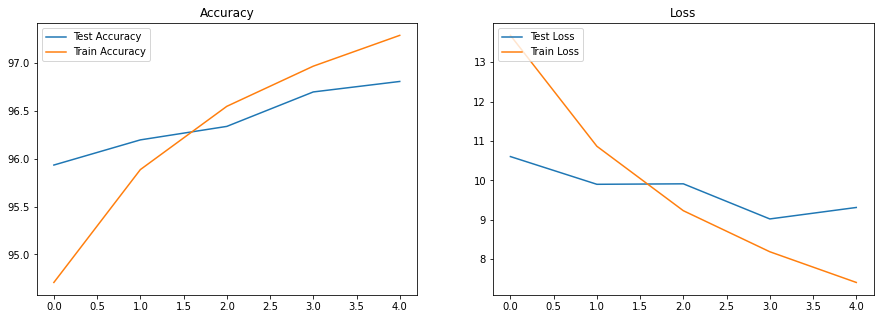

In [70]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(testAcc)
axs[0].plot(trainAcc)
axs[0].legend(['Test Accuracy', 'Train Accuracy'], loc='upper left')
axs[0].set_title("Accuracy")
axs[1].plot(testLosses)
axs[1].plot(trainLosses)
axs[1].legend(['Test Loss', 'Train Loss'], loc='upper left')
axs[1].set_title("Loss")


...and get our new and vastly improved test accuracy!

In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

## User Input

We can now use our model to predict the sentiment of any sentence we give it. As it has been trained on movie reviews, the sentences provided should also be movie reviews.

When using a model for inference it should always be in evaluation mode. If this tutorial is followed step-by-step then it should already be in evaluation mode (from doing `evaluate` on the test set), however we explicitly set it to avoid any risk.

Our `predict_sentiment` function does a few things:
- sets the model to evaluation mode
- tokenizes the sentence, i.e. splits it from a raw string into a list of tokens
- indexes the tokens by converting them into their integer representation from our vocabulary
- gets the length of our sequence
- converts the indexes, which are a Python list into a PyTorch tensor
- add a batch dimension by `unsqueeze`ing 
- converts the length into a tensor
- squashes the output prediction from a real number between 0 and 1 with the `sigmoid` function
- converts the tensor holding a single value into an integer with the `item()` method

We are expecting reviews with a negative sentiment to return a value close to 0 and positive reviews to return a value close to 1.

In [71]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

An example negative review...

In [72]:
predict_sentiment(model, "This film is terrible")

0.9876003265380859

An example positive review...

In [73]:
predict_sentiment(model, "This film is great")

0.018964894115924835

## Next Steps

We've now built a decent sentiment analysis model for movie reviews! In the next notebook we'll implement a model that gets comparable accuracy with far fewer parameters and trains much, much faster.